In [16]:
import pandas as pd
import logging
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS, RNN
from utilsforecast.plotting import plot_series
from neuralforecast.core import NeuralForecast
from neuralforecast.auto import AutoNHITS
import plotly.express as px
import plotly.graph_objects as go


In [24]:
logging.getLogger('pytorch_lightning').setLevel(logging.INFO)

In [18]:
Y_df = pd.read_csv("/mnt/data/oe215/rhindrikson/datasets/load/entsoe/data.csv")
Y_df["ds"] = pd.to_datetime(Y_df["ds"])

In [19]:
print(Y_df.dtypes)
print(Y_df.head())

Unnamed: 0                     int64
ds                    datetime64[ns]
y                            float64
unique_id                     object
week_day                       int64
is_holiday                     int64
day_before_holiday             int64
day_after_holiday              int64
dtype: object
   Unnamed: 0                  ds           y unique_id  week_day  is_holiday  \
0           0 2022-01-01 00:00:00  41535.7650      load         5           1   
1           1 2022-01-01 01:00:00  40480.9050      load         5           1   
2           2 2022-01-01 02:00:00  39563.9150      load         5           1   
3           3 2022-01-01 03:00:00  39338.1950      load         5           1   
4           4 2022-01-01 04:00:00  38826.6425      load         5           1   

   day_before_holiday  day_after_holiday  
0                   0                  0  
1                   0                  0  
2                   0                  0  
3                   0          

In [ ]:
# create a futr_df

In [73]:
horizon = 24
nf_models = [NHITS(h=horizon,
                hist_exog_list = ['week_day', 'is_holiday', 'day_before_holiday', 'day_after_holiday'], # <- Historical exogenous variables
                futr_exog_list = ['week_day', 'is_holiday', 'day_before_holiday', 'day_after_holiday'], # <- Future exogenous variables
                input_size=2 * horizon,
                max_steps=100,               # Number of steps to train
                n_freq_downsample=[2, 1, 1] # Downsampling factors for each stack output
                ),
             LSTM(input_size=2 * horizon,
               h=horizon,                    # Forecast horizon
               hist_exog_list = ['week_day', 'is_holiday', 'day_before_holiday', 'day_after_holiday'], # <- Historical exogenous variables
               futr_exog_list = ['week_day', 'is_holiday', 'day_before_holiday', 'day_after_holiday'], # <- Future exogenous variables
               max_steps=500,                # Number of steps to train
               scaler_type='standard',       # Type of scaler to normalize data
               encoder_hidden_size=64,       # Defines the size of the hidden state of the LSTM
               decoder_hidden_size=64,), 
         ]
# Instantiate StatsForecast class as sf
nf = NeuralForecast(
    models=nf_models,
    freq='h', 
)


[rank: 0] Seed set to 1
[rank: 0] Seed set to 1


In [74]:
nf.fit(df=Y_df, verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
12.043    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | LSTM          | 52.5 K | train
4 | mlp_decoder  | MLP           | 4.5 K  | train
-------------------------------------------------------
57.0 K    Trainable params
0         Non-trainable params
57.0 K    Total params
0.228     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.


In [75]:
Y_hat_df = nf.predict()
print(Y_hat_df.head())

ValueError: Models require the following future exogenous features: {'is_holiday', 'day_before_holiday', 'day_after_holiday', 'week_day'}. Please provide them through the `futr_df` argument.

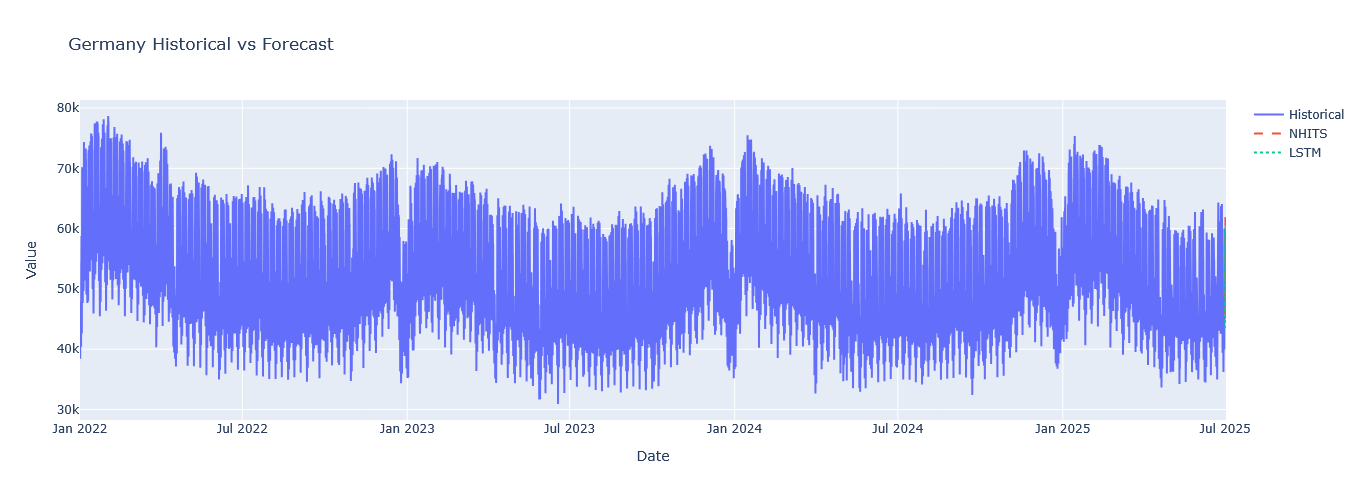

In [69]:
# Add historical data
fig = go.Figure()
fig.add_trace(go.Scatter(x=Y_df['ds'], y=Y_df['y'],
                         mode='lines',
                         name='Historical'))

# Add forecast data
fig.add_trace(go.Scatter(x=Y_hat_df['ds'], y=Y_hat_df['NHITS'],
                         mode='lines',
                         name='NHITS',
                         line=dict(dash='dash')))  # Optional: dashed line for forecast

fig.add_trace(go.Scatter(x=Y_hat_df['ds'], y=Y_hat_df['LSTM'],
                         mode='lines',
                         name='LSTM',
                         line=dict(dash='dot')))  # Optional: dashed line for forecast

fig.update_layout(title='Germany Historical vs Forecast',
                  width=1400, height=500,
                  xaxis_title='Date',
                  yaxis_title='Value')
fig.show()

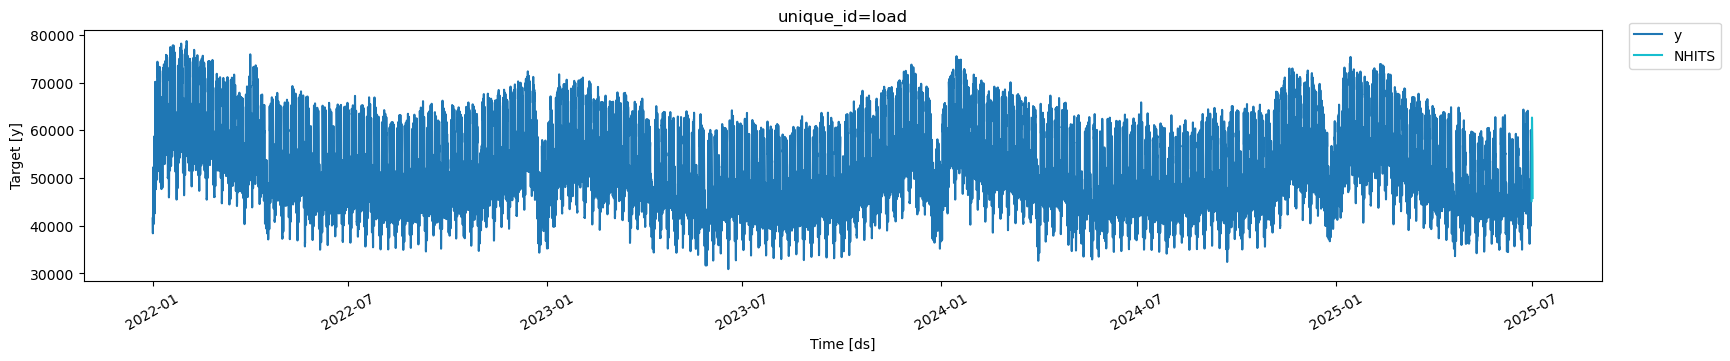

In [35]:
plot_series(Y_df, Y_hat_df)